# Imports

In [1]:
# Basics
import pandas as pd # for data loading and manipulation
import matplotlib.pyplot as plt # for visualizations

# TensorFlow
import tensorflow as tf       # Core TensorFlow library
from tensorflow import keras  # Keras API for model building
from keras import layers      # Keras layers like Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint  # import necessary callback classes

# Load Preprocessed Data

Here, we load the datasets created by our preprocessing notebook. These files contain the training and validation data that has been cleaned, scaled, and one-hot encoded. It's crucial that we load the correct files to match the model architecture we will define.

In [2]:
# Load the training features into a pandas DataFrame
X_train = pd.read_csv("../data/X_train_processed.csv")
# Load the validation features into a pandas DataFrame
X_val = pd.read_csv("../data/X_val_processed.csv")
# Load the training target labels into a pandas DataFrame
y_train = pd.read_csv("../data/y_train.csv")
# Load the validation target labels into a pandas DataFrame
y_val = pd.read_csv("../data/y_val.csv")

In [3]:
# Flatten the target DataFrames to 1D numpy arrays, as required by Keras
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

In [4]:
# Print the shapes of the loaded datasets to confirm they are correct
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (80000, 24)
X_val shape: (20000, 24)
y_train shape: (80000,)
y_val shape: (20000,)


The output confirms we have loaded the correct data. We can see that X_train has a shape of (80000, 24), reflecting the 24 features produced by our one-hot encoding pipeline. The data is now correctly shaped and ready for the modeling stage.

Before defining the model, we'll perform one last check to ensure the class distribution (the percentage of high-risk vs. low-risk customers) is the same in both our training and validation sets.

In [5]:
# Create a pandas Series from the y_train numpy array to use value_counts()
y_train_series = pd.Series(y_train)
# Create a pandas Series from the y_val numpy array
y_val_series = pd.Series(y_val)

# Print the training set class balance as a percentage
print("\nTraining set class balance (%):")
# Calculate and display the percentage of each class in the training set
print(y_train_series.value_counts(normalize=True) * 100)

# Print the validation set class balance as a percentage
print("\nValidation set class balance (%):")
# Calculate and display the percentage of each class in the validation set
print(y_val_series.value_counts(normalize=True) * 100)


Training set class balance (%):
0    71.0025
1    28.9975
Name: proportion, dtype: float64

Validation set class balance (%):
0    71.0
1    29.0
Name: proportion, dtype: float64


We’ve successfully loaded and inspected the training and validation datasets. The shapes of the feature matrices and target vectors are exactly what we expected, and the class balance in both splits mirrors the original distribution — 71% for class 0 and 29% for class 1. That confirms our preprocessing and saving steps worked as intended, and we’re starting off with clean, well-structured data. Time to move on to building the model!

# Building the Baseline Model

Now that our data is clean and aligned, let’s define, compile, and prepare the neural network for binary classification of credit risk.

## Define the Model Architecture

First, we'll define the structure of our neural network. We start by dynamically getting the number of features from our X_train dataset to ensure the input layer is correctly sized. Our architecture will consist of two hidden Dense layers with ReLU activations, Dropout layers for regularization, and a final sigmoid output layer to produce a probability.

In [6]:
# Count columns (features) in the training DataFrame
num_features = X_train.shape[1]  # shape: (rows, cols); index 1 is cols
print(f"Number of features: {num_features}")  # confirm we pulled the right value (should be 24)

Number of features: 24


In [7]:
# Build the Sequential model with an explicit Input layer
model = keras.Sequential([
    # Defines the expected shape of the input, which is a vector of `num_features`
    keras.Input(shape=(num_features,)),
    # First hidden layer with 64 neurons and ReLU activation function
    layers.Dense(64, activation='relu'),
    # Dropout layer to prevent overfitting by randomly setting 30% of inputs to 0
    layers.Dropout(0.3),
    # Second hidden layer with 32 neurons and ReLU activation function
    layers.Dense(32, activation='relu'),
    # Another Dropout layer for regularization
    layers.Dropout(0.3),
    # Final output layer with 1 neuron and a sigmoid activation function
    # Sigmoid outputs a probability between 0 and 1, perfect for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Displays the architecture, output shapes, and number of parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

The model summary confirms our architecture is correctly defined. 
- The 1,600 parameters in the first dense layer correctly correspond to our 24 input features ((24 inputs * 64 neurons) + 64 biases = 1600).
- The subsequent layer parameters are also correct.

## Compile the Model

Next, we compile the model to configure its learning process. We specify the optimizer, loss function, and evaluation metrics that guide weight updates during training.
- Adam optimizer adapts the learning rate for each parameter by combining momentum and RMSProp, which accelerates convergence. It uses bias-corrected moving averages of gradients and squared gradients for stable updates. This optimizer generally works well out of the box with minimal tuning.
- Binary crossentropy computes the divergence between true labels and predicted probabilities, directly optimizing the log-likelihood of the correct class. It heavily penalizes confident but incorrect predictions, leading to better-calibrated outputs. Its smooth gradients help ensure stable training dynamics.
- Accuracy calculates the proportion of correct predictions over all samples, offering an intuitive measure of overall performance. It serves as a quick sanity check to confirm the model is learning. However, it can mask poor performance on minority classes when data is imbalanced.
- Precision measures the fraction of positive predictions that are actually correct. It’s crucial when false positives carry high costs, such as mislabeling low-risk customers as defaulters. A high precision ensures our “will default” alerts are trustworthy. Basically, of all borrowers flagged as “likely to default,” what fraction actually defaults? Controls the cost of false alarms.
- Recall quantifies the fraction of actual positives detected by the model. It’s vital when missing positive cases is costly, like failing to flag a genuine defaulter. Maximizing recall ensures comprehensive coverage of the risk pool. So, of all actual defaulters, what fraction did we catch? Crucial for minimizing missed high-risk customers (false negatives).
- ROC AUC summarizes the trade-off between true positive rate and false positive rate across all thresholds. It provides a threshold-agnostic measure of the model’s ability to rank positive instances higher than negative ones. Values closer to 1 indicate strong discriminative power. In other wowrds, it measures how well the model separates defaulters from non-defaulters across every possible threshold. Good for general model comparison.

In [8]:
# Compile the model to configure its learning process
model.compile(
    # Adam is an efficient optimizer that adapts the learning rate during training
    optimizer='adam',
    # Binary crossentropy is the standard loss function for binary classification problems
    loss='binary_crossentropy',
    # List of metrics to monitor during training and evaluation
    metrics=[
        'accuracy',                                     # The proportion of correct predictions
        tf.keras.metrics.AUC(name='auc'),               # Area Under the ROC Curve, great for imbalanced classes
        tf.keras.metrics.Precision(name='precision'),   # The accuracy of positive predictions
        tf.keras.metrics.Recall(name='recall')          # The ability to find all positive samples
    ]
)

The model now has its learning parameters defined. The last step before training is to set up our callbacks.

## Set Up Callbacks

Callbacks are essential for efficient training. We will configure EarlyStopping to halt training if the validation AUC stops improving, and ModelCheckpoint to save the best version of the model based on that same metric. AUC is generally a solid choice for a checkpoint because it captures the model’s ability to rank defaulters vs. non-defaulters across every possible threshold, it’s robust to class imbalance and doesn’t force us into a single cutoff.  
- If the priority is catching as many defaulters as possible (even at the expense of more false alarms), we could instead monitor recall. That will stop training once we’ve maximized our coverage of true defaulters.  
- On the other hand, if false positives (wrongly flagging safe customers) are especially costly, precision is a better single-metric guide: it ensures that the positives we do predict are trustworthy.  
- Accuracy is the least advisable. On imbalanced credit-risk data it can look deceptively high even while we’re missing most defaulters.

In [9]:
# EarlyStopping callback will stop training when a monitored metric has stopped improving
early_stop = EarlyStopping(
    monitor='val_auc',           # metric to watch on validation data
    patience=5,                  # how many epochs with no improvement before stopping
    mode='max',                  # We want to maximize the AUC, so the mode is 'max'
    restore_best_weights=True    # Restores model weights from the epoch with the best value of the monitored metric
)

# ModelCheckpoint callback saves the model after every epoch where the monitored metric improves
checkpoint = ModelCheckpoint(
    filepath='../models/baseline_credit_model.keras', # Path to save the model file
    monitor='val_auc',                                # The metric to watch on validation data
    mode='max',                                       # We want to maximize the AUC
    save_best_only=True                               # only keep the checkpoint with the highest val_auc
)

Our callbacks are now ready. We have everything we need to start training the model.

# Train the Model

This section is where we'll execute the training. We will capture the training process in a history object, which we'll use in the next section to visualize the model's performance.

In [10]:
# Train the model using the .fit() method. The output is stored in the 'history' object
history = model.fit(                        # launch training and store per-epoch logs
    X_train,                                # input features for training (customer data)
    y_train,                                # binary targets for training (0 or 1 default labels)
    validation_data=(X_val, y_val),         # features/labels to validate after each epoch
    epochs=50,                              # maximum epochs (full passes through train set)
    batch_size=32,                          # samples per gradient update
    callbacks=[early_stop, checkpoint]      # early stopping & best-model checkpointing
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 759us/step - accuracy: 0.7624 - auc: 0.7740 - loss: 0.5049 - precision: 0.6365 - recall: 0.4371 - val_accuracy: 0.8011 - val_auc: 0.8272 - val_loss: 0.4475 - val_precision: 0.6973 - val_recall: 0.5552
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step - accuracy: 0.8000 - auc: 0.8237 - loss: 0.4545 - precision: 0.6942 - recall: 0.5547 - val_accuracy: 0.8072 - val_auc: 0.8335 - val_loss: 0.4394 - val_precision: 0.7009 - val_recall: 0.5843
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.8036 - auc: 0.8325 - loss: 0.4446 - precision: 0.7009 - recall: 0.5685 - val_accuracy: 0.8070 - val_auc: 0.8358 - val_loss: 0.4367 - val_precision: 0.7088 - val_recall: 0.5679
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step - accuracy: 0.8037 - auc: 0.8324 - loss: 0.4423 - precision: 0.7009 - recall: 0.5641 - val_accuracy: 0.8080 - val_auc: 0.8380 - val_loss: 0.4333 - val_precision: 0.7119 - val_recall: 0.5679
Epoch 5/50
2500/

The model has now completed training. The logs above show the loss, accuracy, auc, precision, and recall for each epoch on both the training and validation data. Thanks to EarlyStopping, the training automatically halted when the val_auc stopped improving, and the restore_best_weights=True setting ensures our model object now contains the weights from the single best-performing epoch.

# Visualize Training History

After training the model, the best way to understand its performance is to visualize the metrics over each epoch. Plotting the training and validation curves for metrics like loss, AUC, and precision helps us diagnose issues like overfitting and determine if the model converged effectively.

## Convert Training History to a DataFrame

The history object returned by the .fit() method contains a dictionary where keys are the metric names and values are the scores from each epoch. For easier handling and plotting with Matplotlib, we'll convert this dictionary into a pandas DataFrame.

In [11]:
# The history.history object is a dictionary containing the metrics from each epoch
print(history.history.keys()) # Verify names of keys

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


In [12]:
# Convert this dictionary into a pandas DataFrame for easier manipulation and plotting
df_history = pd.DataFrame(history.history)

# Display the first 5 rows of the new DataFrame to confirm its structure
print("Training history DataFrame head:")
df_history.head()

Training history DataFrame head:


,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
0,0.781687,0.800700,0.479928,0.668647,0.489913,0.80110,0.827160,0.447464,0.697272,0.555172
1,0.800200,0.823792,0.453751,0.694973,0.554229,0.80715,0.833534,0.439396,0.700931,0.584310
2,0.803150,0.831556,0.444476,0.698667,0.564704,0.80705,0.835777,0.436730,0.708844,0.567931
3,0.805750,0.833257,0.440796,0.704126,0.569359,0.80805,0.838027,0.433288,0.711908,0.567931
4,0.806363,0.834677,0.438966,0.707077,0.567204,0.80830,0.839552,0.433184,0.715004,0.563621


The history is now in a clean, tabular format. Each row represents an epoch, and each column represents a metric, making it simple to plot.

## Plot Training and Validation Metrics

Now, we'll loop through our key metrics and generate a separate subplot for each one. Each plot will show both the training curve and the validation curve, allowing for a direct comparison to assess generalization and overfitting.

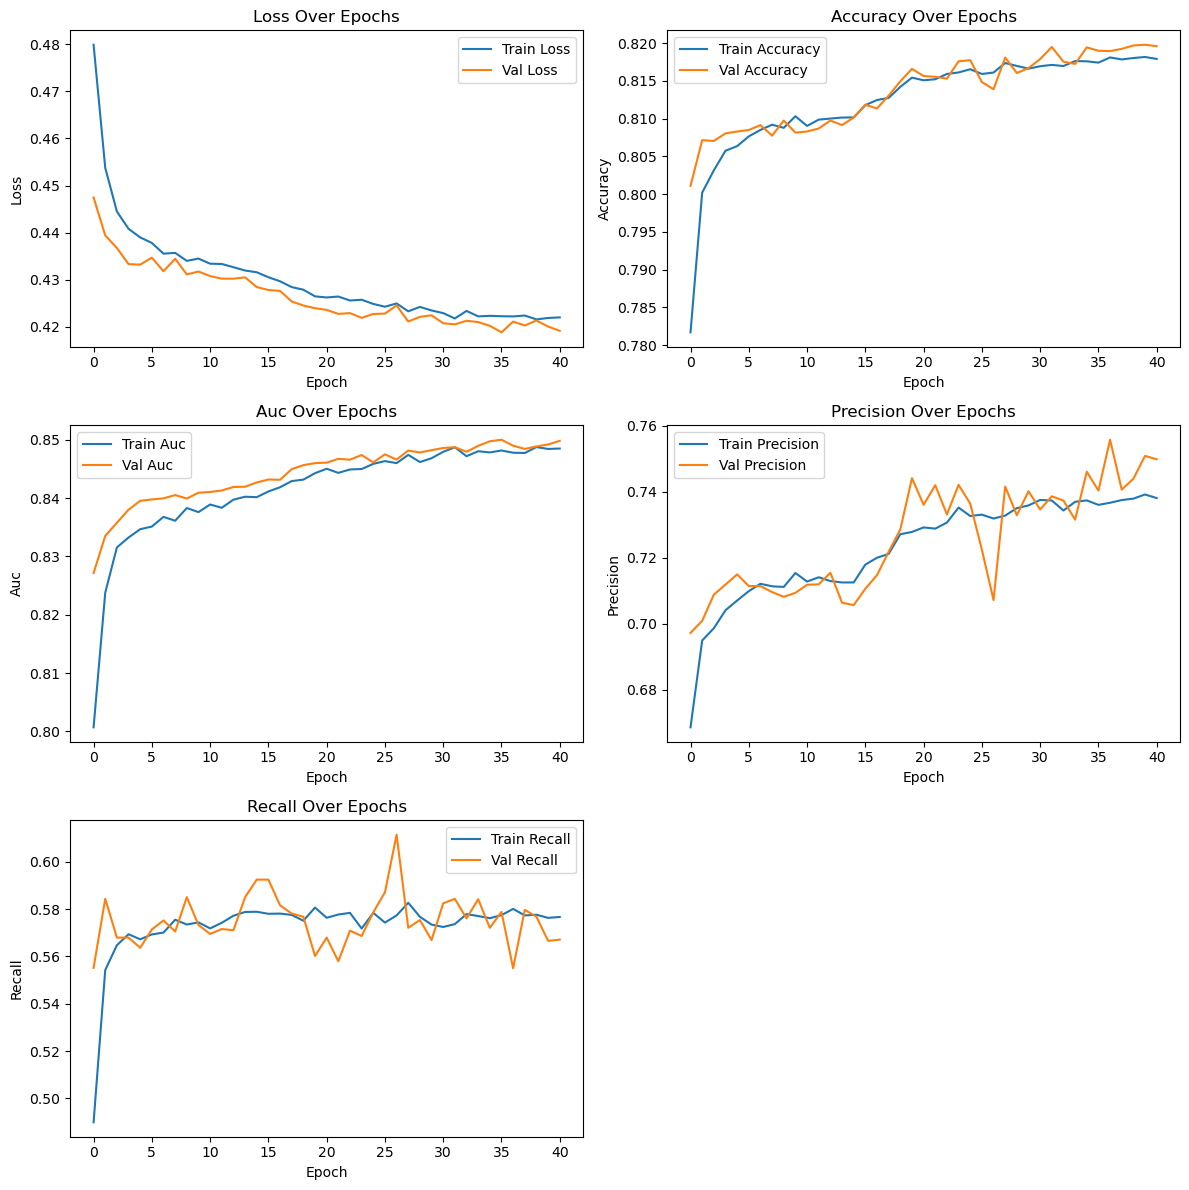

In [13]:
# Define the list of metrics we want to plot from our history object
metrics_to_plot = ['loss', 'accuracy', 'auc', 'precision', 'recall']

# Determine grid size for subplots: 2 columns, enough rows to fit all metrics
n_metrics = len(metrics_to_plot)             # total number of metrics to plot
n_cols = 2                                   # number of columns in the figure
n_rows = (n_metrics + n_cols - 1) // n_cols  # compute required rows using ceiling division

# Create a figure to hold all the subplots, with a dynamic size based on the number of rows
plt.figure(figsize=(12, 4 * n_rows))

# Loop through each metric and plot its training & validation curves
for idx, metric in enumerate(metrics_to_plot):
    plt.subplot(n_rows, n_cols, idx + 1)             # select position of the subplot
    plt.plot(df_history[metric],                     # plot training metric values
             label=f'Train {metric.capitalize()}')   # label for the training curve
    plt.plot(df_history[f'val_{metric}'],            # plot validation metric values
             label=f'Val {metric.capitalize()}')     # label for the validation curve
    plt.title(f'{metric.capitalize()} Over Epochs')  # title reflecting the metric
    plt.xlabel('Epoch')                              # x-axis label
    plt.ylabel(metric.capitalize())                  # y-axis label
    plt.legend()                                     # add legend to distinguish curves

plt.tight_layout()  # adjust subplot spacing to prevent overlap
plt.show()          # display all subplots

**Loss:** 
- The training and validation loss curves decrease steadily and converge nicely around a value of ~0.42.
- The two curves track each other very closely, which is a strong indicator that the model is not overfitting and generalizes well to unseen data.
- The curves begin to plateau around epoch 25, showing that EarlyStopping was effective in halting the training once performance stopped improving significantly.

**Accuracy:** 
- Both training and validation accuracy climb in lockstep and plateau at approximately 82%.
- The tight alignment between the two curves further confirms that the model's overall correctness is consistent between the data it trained on and new validation data.

**AUC (Area Under the Curve):**
- This is a key metric for our imbalanced dataset.
- Both curves climb smoothly and plateau at a strong ~0.85.
- An AUC of 0.85 indicates that the model has a very good ability to correctly distinguish between high-risk and low-risk applicants.

**Precision:** 
- Precision trends upward and settles around 0.74 (or 74%).
- This is a good result, meaning that when the model identifies a customer as high-risk, it is correct about three-quarters of the time.
- This helps minimize the cost of investigating customers who are incorrectly flagged (false positives).

**Recall:** 
- This metric is the most volatile, hovering between 0.56 and 0.60 after an initial climb.
- This means the model successfully identifies roughly 58% of all the actual high-risk customers in the dataset.
- The moderate score and the volatility highlight the classic precision-recall trade-off.
- We could adjust the model or decision threshold to improve this recall score, but likely at the cost of lower precision.

# Conclusion

This notebook successfully established a baseline feedforward neural network for credit risk classification. The model achieved a strong validation AUC of approximately 0.85, indicating a good ability to distinguish between high-risk and low-risk applicants. This provides a solid performance benchmark for future improvements.

The next steps in this project are:
- Hyperparameter Tuning: Experiment with different model architectures and training parameters to improve performance.
- Model Explanation (potentially): Use SHAP to interpret the predictions of the final, tuned model.